# Thought Cascade: Building and Evaluating Agentic AI Systems with Small Language Models

*An Interactive Journey into Iterative Intelligence*

## Submission Requirements

1. **Complete all coding implementations** marked with `TODO` in this notebook (for example, Questions 1, 4, 5, and 6).
2. **Complete all analysis sections** explicitly labeled "Required Analysis".
3. **Run all cells** so that key tables and plots (e.g., single-shot metrics, STRICT tests, QuixBugs results, and ReAct loop outcomes) are visible in your saved notebook.
4. **Follow course submission instructions** for exporting your answers (avoid submitting unnecessarily long full-notebook PDFs).

## Introduction: The Rise of Agentic AI

Consider how humans solve complex problems. We rarely get the answer right on the first try. Instead, we form a hypothesis, test it, observe what happens, and refine our approach. We repeat this cycle until we succeed.

Traditional single-shot prompting forces models to "think" once and commit to an answer immediately. This is like asking a student to solve a complex math problem without scratch paper or the ability to check their work. Agentic AI, by contrast, gives models the ability to work through problems systematically.

### The Agentic Loop

At its core, an agentic system operates in a loop of **Reasoning**, **Acting**, and **Observing**.

![The ReAct Loop: Reasoning, Acting, and Observing](images/react_diagram.png)
*Figure 1: The ReAct Loop (Source: [Yao et al., 2022](https://react-lm.github.io/))*

**What is Agentic AI?**

Agentic AI represents a fundamental shift in how we interact with language models. Instead of treating models as passive question-answering systems, we treat them as active problem solvers. These systems can reason about problems iteratively, act in their environment using tools, observe the results, and adapt their approach based on feedback.

The key insight is that **intelligence emerges not from model size alone, but from the ability to iterate and self-correct**.

**The ReAct Framework**

In this notebook, we'll focus on **ReAct** (Reasoning and Acting), one of the most successful patterns for building agentic systems. ReAct interleaves reasoning traces with actions, creating a feedback loop that enables self-improvement. The principles we'll learn—decomposition, tool use, memory, and self-evaluation—apply broadly to any agentic system.

## Learning Objectives

By completing this notebook, you will:

1. **Understand** the theoretical foundations of agentic AI and why iteration beats size
2. **Build** complete agentic systems using the ReAct pattern
3. **Measure** system performance at the component level, not just end-to-end
4. **Design** tools that enable effective agent-environment interaction
5. **Compare** different models and understand their trade-offs in agentic contexts
6. **Diagnose** failure modes and implement recovery strategies
7. **Apply** agentic patterns to diverse problem domains

## Section 0: Environment Setup and Model Selection

### Understanding Local Model Inference

We'll use **Hugging Face Transformers** for running models locally. This approach has several advantages:
- **Privacy**: Your data never leaves your machine
- **Cost**: No API fees or rate limits
- **Control**: Full control over model versions and configurations
- **Learning**: Better understanding of model behavior and limitations

The models we'll use are instruction-tuned versions that can run on consumer hardware (GPU recommended but CPU works).

In [1]:
# Install required packages (uncomment if needed)
%pip install transformers torch pandas matplotlib seaborn numpy accelerate

import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass
import re
import traceback
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Packages imported successfully")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Users/ming/Dropbox/learn-ml-by-building/ml_lectures_env/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/ming/Dropbox/learn-ml-by-building/ml_lectures_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Packages imported successfully


### Hugging Face Model Wrapper

We create a wrapper class that mimics the Ollama API but uses Hugging Face Transformers.
This allows us to use the same interface throughout the notebook.

In [2]:
class HFModelWrapper:
    """Wrapper to use Hugging Face models with Ollama-like interface."""
    
    def __init__(self):
        self.models = {}        # Cache loaded models by alias (e.g., 'gemma2:2b')
        self.tokenizers = {}    # Keep matching tokenizers alongside models
        self.device = (
            "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
            else "cuda" if torch.cuda.is_available()
            else "cpu"
        )  # Prefer GPU when available
        print(f"Using device: {self.device}")
        
    def pull(self, model_name: str):
        """Load a model (mimics ollama.pull)."""
        # Map ollama model names to HuggingFace model IDs
        model_mapping = {
            "gemma2:2b": "google/gemma-2-2b-it",
            "qwen2.5:3b": "Qwen/Qwen2.5-3B-Instruct",
            "llama3.2:3b": "meta-llama/Llama-3.2-3B-Instruct",
            "smollm:360m": "HuggingFaceTB/SmolLM-360M-Instruct"
        }
        # TODO: Students - Update these paths if you have models downloaded locally from Project 2
        # If these paths are not found, the code will automatically download from HuggingFace.
        # You can also set these to None to force a download.
        local_model_dirs = {
            "gemma2:2b": os.path.abspath(
                os.path.join("..", "Project 2 Neural Archaeology (instructor)", "models", "gemma-2-2b-it")
            ),
            "smollm:360m": os.path.abspath(
                os.path.join("..", "Project 2 Neural Archaeology (instructor)", "models", "SmolLM-360M-Instruct")
            )
        }
        
        if model_name not in model_mapping:
            raise ValueError(f"Unknown model: {model_name}")
            
        hf_model_id = model_mapping[model_name]
        local_dir = local_model_dirs.get(model_name)
        if local_dir and os.path.isdir(local_dir):
            print(f"Loading {model_name} from local directory ({local_dir})...")
            hf_model_id = local_dir
        else:
            print(f"Loading {model_name} from HuggingFace ({hf_model_id})...")
        
        try:
            # Load tokenizer
            self.tokenizers[model_name] = AutoTokenizer.from_pretrained(hf_model_id)
            
            # Load model with appropriate settings
            self.models[model_name] = AutoModelForCausalLM.from_pretrained(
                hf_model_id,
                torch_dtype=torch.float16 if self.device != "cpu" else torch.float32,
                device_map="auto" if self.device == "cuda" else None,
                low_cpu_mem_usage=True
            )
            
            if self.device != "cuda":
                self.models[model_name] = self.models[model_name].to(self.device)
                
            print(f"  ✓ Model {model_name} loaded successfully")
            
        except Exception as e:
            print(f"  ✗ Error loading {model_name}: {e}")
            raise
    
    def chat(self, model: str, messages: List[Dict[str, str]], **kwargs) -> Dict:
        """Generate response (mimics ollama.chat)."""
        if model not in self.models:
            raise ValueError(f"Model {model} not loaded. Call pull() first.")
        
        # Format messages into a single prompt string for generate()
        prompt = self._format_messages(messages)
        
        # Tokenize
        tokenizer = self.tokenizers[model]
        inputs = tokenizer(prompt, return_tensors="pt").to(self.device)
        
        # Generate
        with torch.no_grad():
            outputs = self.models[model].generate(
                **inputs,
                max_new_tokens=kwargs.get('max_tokens', 512),
                temperature=kwargs.get('temperature', 0.7),
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode
        response_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        
        # Return in Ollama format
        return {
            'message': {
                'content': response_text.strip()
            }
        }
    
    def _format_messages(self, messages: List[Dict[str, str]]) -> str:
        """Format messages into a prompt string."""
        prompt = ""
        for msg in messages:
            role = msg['role']
            content = msg['content']
            if role == 'user':
                prompt += f"User: {content}\n\n"
            elif role == 'assistant':
                prompt += f"Assistant: {content}\n\n"
            elif role == 'system':
                prompt += f"System: {content}\n\n"
        
        prompt += "Assistant: "
        return prompt

# Create global instance
ollama = HFModelWrapper()
print("HuggingFace model wrapper initialized")

Using device: mps
HuggingFace model wrapper initialized


### Model Selection: Understanding Trade-offs

A compact comparison table for quick reference during the exercises.

| Model     | Params | Provider         | Architecture                             | Strengths                             | Trade-offs                         |
|-----------|--------|------------------|------------------------------------------|---------------------------------------|------------------------------------|
| Gemma 2   | 2B     | Google DeepMind  | Transformer + RoPE                       | Reasoning; instruction following      | Verbose; slower at structured output |
| Qwen 2.5  | 3B     | Alibaba Cloud    | Enhanced transformer; improved tokenization | Structured output (JSON/code); multilingual | Less creative; more rigid         |
| Llama 3.2 | 3B     | Meta             | Transformer + RMSNorm                    | Balanced general-purpose              | Needs precise prompting            |

In [3]:
# Download and test models
models_to_test = {
    "gemma2:2b": "Google's Gemma 2B - Optimized for reasoning",
    "qwen2.5:3b": "Alibaba's Qwen 2.5 3B - Structured output specialist", 
    "llama3.2:3b": "Meta's Llama 3.2 3B - General purpose model",
    "smollm:360m": "SmolLM 360M - Very fast local baseline"
}

print("Loading models from HuggingFace (this may take several minutes)...")
print("Note: Each model is approximately 4-6GB. First run will download from HuggingFace.\n")
print("Note: You may need to authenticate with HuggingFace for some models (e.g., Llama).\n")
print("      Run: huggingface-cli login\n")

# For this demo, let's just load one small model to start
# Students can uncomment others as needed
models_to_load = ["gemma2:2b"]  # Start with SmolLM for speed

for model_name in models_to_load:
    description = models_to_test[model_name]
    print(f"\n{model_name}: {description}")
    try:
        # Pull the model
        ollama.pull(model_name)
        
        # Test with simple prompt
        print("  Testing model...")
        response = ollama.chat(
            model=model_name,
            messages=[{'role': 'user', 'content': 'Say "Hello" in one word'}]
        )
        print(f"  Model ready. Test response: {response['message']['content'][:50]}")
    except Exception as e:
        print(f"  Error loading model: {e}")
        print(f"  You may need to: pip install accelerate")
        print(f"  Or for Llama models: huggingface-cli login")

# Select primary model for exercises
PRIMARY_MODEL = "gemma2:2b"  # Students can change this
print(f"\nPrimary model selected: {PRIMARY_MODEL}")

Loading models from HuggingFace (this may take several minutes)...
Note: Each model is approximately 4-6GB. First run will download from HuggingFace.

Note: You may need to authenticate with HuggingFace for some models (e.g., Llama).

      Run: huggingface-cli login


gemma2:2b: Google's Gemma 2B - Optimized for reasoning
Loading gemma2:2b from local directory (/Users/ming/Dropbox/learn-ml-by-building/Project 2 Neural Archaeology (instructor)/models/gemma-2-2b-it)...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  ✓ Model gemma2:2b loaded successfully
  Testing model...
  Model ready. Test response: Hello

Primary model selected: gemma2:2b


## Section 1: Understanding the Limits of Single-Shot Inference

### 1.1 The Fundamental Challenge

To understand why agentic AI is necessary, let's examine a concrete problem: debugging code. This task requires:

1. **Understanding** the intended behavior
2. **Identifying** the bug
3. **Reasoning** about the fix
4. **Implementing** the correction
5. **Verifying** the solution

When we force a model to do all of this in a single pass, we're asking it to perfectly execute a complex, multi-step process without any opportunity for verification or correction. This is analogous to writing code without testing it, or solving a math problem without checking your work.

**Case Study: A Binary Search Bug**: We'll use a simple but instructive example throughout this notebook: a buggy binary search implementation. While the bug itself is straightforward, it reveals fundamental patterns that apply to more complex problems.

### 1.2 Minimal Spec and Tests

In [4]:
# Define our buggy code example (adapted from a classic binary search implementation)
BUGGY_BINARY_SEARCH = '''
def binary_search(arr, target):
    """Return the leftmost index of target in the sorted list arr, or -1 if not found.

    If target appears multiple times, this function should return the index of the
    first occurrence from the left (i.e., the smallest index i such that arr[i] == target).
    If target does not appear in arr, it should return -1.
    """
    left, right = 0, len(arr)
    while left < right:
        mid = (left + right) // 2
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            left = mid + 1
        else:
            right = mid - 1  
    return -1
'''
# right = mid - 1  # BUG: off-by-one in right boundary

BINARY_SEARCH_TEST_CASES = [
    (([1, 3, 5, 7], 1), 0),
    (([1, 3, 5, 7], 7), 3),
    (([1, 3, 5, 7], 2), -1),
    (([], 1), -1),
]

print("Buggy Code:")
print(BUGGY_BINARY_SEARCH)
print("\nTest Cases:")
for (arr, target), expected in BINARY_SEARCH_TEST_CASES:
    print(f"  binary_search({arr}, {target}) should return {expected}")

Buggy Code:

def binary_search(arr, target):
    """Return the leftmost index of target in the sorted list arr, or -1 if not found.

    If target appears multiple times, this function should return the index of the
    first occurrence from the left (i.e., the smallest index i such that arr[i] == target).
    If target does not appear in arr, it should return -1.
    """
    left, right = 0, len(arr)
    while left < right:
        mid = (left + right) // 2
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            left = mid + 1
        else:
            right = mid - 1  
    return -1


Test Cases:
  binary_search([1, 3, 5, 7], 1) should return 0
  binary_search([1, 3, 5, 7], 7) should return 3
  binary_search([1, 3, 5, 7], 2) should return -1
  binary_search([], 1) should return -1


In [5]:
MINIMAL_TESTS = BINARY_SEARCH_TEST_CASES

### 1.3 Execution Framework for Single-Shot Code

Before we can test different approaches, we need a safe way to execute and validate code. This is a critical component of any agentic system that works with code.

The execution framework must:
- **Isolate** code execution to prevent side effects
- **Capture** both successful results and errors
- **Provide** detailed feedback for debugging
- **Measure** partial success (some tests passing)

In [6]:
def execute_code_safely(code: str, test_cases: List[Tuple[Any, Any]], func_name: str = 'binary_search') -> Dict:
    """
    Safely execute code and run test cases.
    
    This function demonstrates key principles for tool design in agentic systems:
    1. Rich error reporting (not just "failed")
    2. Partial success tracking (not just binary pass/fail)
    3. Detailed diagnostics for debugging
    
    Args:
        code: Python code to execute
        test_cases: List of (input, expected_output) tuples. Each input can be a
            single value or a tuple of arguments (e.g., (array, target) for
            binary_search).
        
    Returns:
        Dictionary with execution results
    """
    results = {
        'compilation': 'success',
        'test_results': [],
        'all_passed': False,
        'pass_rate': 0.0
    }
    
    # Try to execute the code
    try:
        namespace: Dict[str, Any] = {}
        exec(code, namespace)
        if func_name not in namespace:
            results['compilation'] = f'error: {func_name} not found'
            return results
    except SyntaxError as e:
        results['compilation'] = f'syntax error: line {e.lineno}: {e.msg}'
        return results
    except Exception as e:
        results['compilation'] = f'error: {str(e)}'
        return results
    
    # Run test cases
    passed = 0
    for inp, expected in test_cases:
        try:
            if isinstance(inp, (tuple, list)):
                actual = namespace[func_name](*inp)
            else:
                actual = namespace[func_name](inp)
            is_correct = actual == expected
            if is_correct:
                passed += 1
            results['test_results'].append({
                'input': inp,
                'expected': expected,
                'actual': actual,
                'passed': is_correct
            })
        except Exception as e:
            results['test_results'].append({
                'input': inp,
                'expected': expected,
                'actual': f'error: {str(e)}',
                'passed': False
            })
    
    results['all_passed'] = passed == len(test_cases)
    results['pass_rate'] = passed / len(test_cases) if test_cases else 0
    
    return results

# Test the helper function
print("Testing our code executor with the buggy code (MINIMAL binary_search tests):")
results = execute_code_safely(BUGGY_BINARY_SEARCH, BINARY_SEARCH_TEST_CASES)
print(f"Compilation: {results['compilation']}")
print(f"Pass rate: {results['pass_rate']:.0%}")
print("\nDetailed results:")
for test in results['test_results']:
    status = "PASS" if test['passed'] else "FAIL"
    print(f"  [{status}] binary_search{test['input']}: expected {test['expected']}, got {test['actual']}")

Testing our code executor with the buggy code (MINIMAL binary_search tests):
Compilation: success
Pass rate: 100%

Detailed results:
  [PASS] binary_search([1, 3, 5, 7], 1): expected 0, got 0
  [PASS] binary_search([1, 3, 5, 7], 7): expected 3, got 3
  [PASS] binary_search([1, 3, 5, 7], 2): expected -1, got -1
  [PASS] binary_search([], 1): expected -1, got -1


In [7]:
def extract_code_only(text: str, func_name: Optional[str] = None) -> str:
    """
    Extract only Python code from an LLM response.
    Prefers fenced code blocks. Falls back to extracting the function block by name.
    
    This is a heuristic extractor for teaching purposes: some valid model
    outputs may still be mis-parsed. A compilation failure can indicate
    either that the LLM did not produce runnable code or that the extractor
    failed to capture it. To be more lenient, inspect the raw model output
    when investigating failures.
    """
    # Prefer fenced code blocks
    m = re.search(r"```(?:python)?\s*([\s\S]*?)```", text, re.IGNORECASE)
    if m:
        return m.group(1).strip()

    cleaned = text.strip()
    if func_name:
        # Find the function definition and capture its indented block.
        # First try a strict line-start match, then fall back to a looser
        # search that handles inline/backticked/bulleted definitions.
        func_def_pattern = rf"(?m)^\s*def\s+{re.escape(func_name)}\s*\("
        m2 = re.search(func_def_pattern, cleaned)
        if not m2:
            # Looser search: look for 'def {func_name}(' anywhere in the text
            loose_pattern = rf"def\s+{re.escape(func_name)}\s*\("
            m3 = re.search(loose_pattern, cleaned)
            if m3:
                # Start the text at the beginning of the 'def' token so it
                # becomes a top-level line for the strict pattern.
                cleaned = cleaned[m3.start():]
                m2 = re.search(func_def_pattern, cleaned)
        if m2:
            start = m2.start()
            tail = cleaned[start:]
            lines = tail.splitlines()
            collected: List[str] = []
            started = False
            for line in lines:
                if not started:
                    if re.match(func_def_pattern, line):
                        started = True
                        collected.append(line)
                    continue
                # Continue collecting indented code lines and comments
                if line.strip() == "":
                    collected.append(line)
                    continue
                if line.startswith(" ") or line.startswith("\t") or line.lstrip().startswith("#"):
                    collected.append(line)
                    continue
                # Stop at next top-level statement or prose
                break
            if collected:
                # Clean up a simple trailing backtick on the def line,
                # which is common when the function is wrapped in markdown
                # like `def binary_search(...):`.
                head = collected[0].rstrip()
                if head.lstrip().startswith("def ") and head.endswith("`"):
                    indent_len = len(collected[0]) - len(collected[0].lstrip())
                    head = head[:-1].rstrip()
                    collected[0] = " " * indent_len + head
                return "\n".join(collected).strip()

    # Fallback: strip common markdown artifacts
    return cleaned.replace('```python', '').replace('```', '').strip()

### 1.4 Single-Shot Debugging Baseline

Let's establish a baseline by attempting to fix the bug with a single prompt. This represents the traditional approach to using language models.

Notice what we're asking the model to do in one step:
1. Parse the code and understand its structure
2. Understand what the code should do from test cases
3. Identify the discrepancy
4. Formulate a fix
5. Generate correct code

All without any ability to test hypotheses or verify its reasoning.

In [8]:
def single_shot_debugging(
    code: str,
    func_name: str,
    test_cases: List[Tuple[Any, Any]],
    model: str = PRIMARY_MODEL,
    max_tokens: int = 512,
) -> Tuple[str, Dict]:
    """Run a *single* model attempt to fix buggy code and evaluate it on tests.

    This helper is used throughout Section 1 to represent the "single-shot" (non-agentic)
    baseline. Each call:

    1. Builds a prompt describing the task, the buggy implementation, and the tests.
    2. Calls the local HF-backed model once via `ollama.chat`.
    3. Extracts the code for `func_name` from the model's response.
    4. Executes that code against the provided `test_cases` using `execute_code_safely`.

    Args:
        code: A string containing the buggy implementation (e.g., BUGGY_BINARY_SEARCH).
        func_name: Name of the function to fix inside `code` (here: always 'binary_search').
        test_cases: List of (input, expected_output) pairs. Each `input` is either:
            - a single argument value, or
            - a tuple/list of arguments (e.g., (arr, target)).
        model: Model identifier understood by the `HFModelWrapper` (typically PRIMARY_MODEL).
        max_tokens: Maximum number of *new* tokens the model may generate for this reply.

    Returns:
        fixed_code: String with the model's proposed implementation of `func_name`.
        results: Dictionary produced by `execute_code_safely`, augmented with a 'model' key.
            The dictionary has at least the following fields:
                - 'compilation': 'success' or an error string if the code could not run.
                - 'all_passed': True iff *all* tests in `test_cases` passed.
                - 'pass_rate': Float between 0.0 and 1.0, fraction of tests that passed.
                - 'test_results': List of per-test dicts with keys 'input', 'expected',
                  'actual', and 'passed'.
                - 'model': Name of the model that produced `fixed_code`.

    Notes for Question 2 (Prompt-Tuning):
        - When designing an alternative prompt (Prompt B), you should only modify the
          *prompt construction* below (the multi-line formatted prompt string).
        - You should NOT change the function signature, return types, or how the
          result dictionary is constructed. Later cells and grading code rely on this
          interface staying the same.
    """
    # Format tests for the prompt
    lines = []
    for inp, expected in test_cases:
        if isinstance(inp, (tuple, list)):
            args_str = ", ".join(repr(x) for x in inp)
        else:
            args_str = repr(inp)
        lines.append(f"{func_name}({args_str}) -> {repr(expected)}")
    tests_str = "\n".join(lines)

    prompt = f"""You are fixing a single Python function.

Task:
- Read the buggy implementation of {func_name} and the tests.
- Produce a corrected implementation that makes all tests pass.

Output format (IMPORTANT):
- Output ONLY Python code.
- Do NOT include any explanations, comments, markdown formatting, or backticks.
- The first line of your reply MUST start with: def {func_name}(
- You may define minimal helper functions if needed, after the main function.

Buggy code:
{code}

Tests that must pass (input -> expected_output):
{tests_str}

Remember: reply with Python code only."""

    response = ollama.chat(
        model=model,
        messages=[{'role': 'user', 'content': prompt}],
        max_tokens=max_tokens,
    )

    fixed_code = extract_code_only(response['message']['content'], func_name=func_name)

    # Test the fixed code
    results = execute_code_safely(fixed_code, test_cases, func_name=func_name)
    results['model'] = model

    return fixed_code, results

# Run single-shot attempt
print("Single-Shot Debugging Attempt (MINIMAL binary_search tests)\n")
print("Sending prompt to model (single-shot, no iterations)...")
fixed_code, results = single_shot_debugging(BUGGY_BINARY_SEARCH, 'binary_search', BINARY_SEARCH_TEST_CASES)

print("\nGenerated code:")
print(fixed_code)
print(f"\nResults:")
print(f"  Success: {results['all_passed']}")
print(f"  Pass rate: {results['pass_rate']:.0%}")
print(f"  Compilation: {results['compilation']}")

if results['compilation'] != 'success':
    print("  Note: Tests were not run due to the compilation error above.")
elif not results['all_passed']:
    print("\n  Failed test details:")
    for test in results['test_results']:
        if not test['passed']:
            print(f"    binary_search{test['input']}: expected {test['expected']}, got {test['actual']}")

Single-Shot Debugging Attempt (MINIMAL binary_search tests)

Sending prompt to model (single-shot, no iterations)...

Generated code:
def binary_search(arr, target):
    """Return the leftmost index of target in the sorted list arr, or -1 if not found.

    If target appears multiple times, this function should return the index of the
    first occurrence from the left (i.e., the smallest index i such that arr[i] == target).
    If target does not appear in arr, it should return -1.
    """
    left, right = 0, len(arr)
    while left < right:
        mid = (left + right) // 2
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            left = mid + 1
        else:
            right = mid - 1  
    return -1

Results:
  Success: True
  Pass rate: 100%
  Compilation: success


**Reflection prompt:** Look closely at the model's "fixed" `binary_search`. Does it actually look different from the original buggy version? If the code hasn't really changed but the tests still pass, what does that suggest about our current test suite? Keep this question in mind—we'll revisit it after we strengthen the specification and tests later in this section.

### Question 1 (Coding, 15 points): Measuring Single-Shot Performance

**Objective**: To understand the variability and limitations of single-shot approaches, we need to measure performance across multiple attempts. Language models are stochastic: they can give different answers to the same prompt. This exercise will reveal the inherent uncertainty in non-agentic approaches.

**Your Task**:
1. Complete the function `measure_single_shot_success` below to systematically measure single-shot performance.
2. Implement the `leftmost_index_or_minus_one` oracle and `build_strict_tests` generator in the "Upgraded Spec and Stronger Tests" section that follows.

This will establish our baseline for comparison with agentic approaches.


### Required Analysis for Question 1

*Hidden Bugs and Test Coverage*: The provided baseline tests are intentionally minimal and may not catch all defects.
After you measure single-shot performance with the minimal tests, immediately strengthen the
specification and tests for this `binary_search` and ask:
- Which edge cases are missing from the tests?
- Would the current tests catch off-by-one errors at boundaries and midpoints?
- What additional cases would you add before shipping to production?

Hint: Try inner targets (e.g., searching for 3 in [1,3,5,7]), adjacent boundaries,
single-element arrays, and duplicates. Then re-run `measure_single_shot_success` with the
stronger tests and compare the new pass rates to the original minimal suite.


### 1.3 Measuring Performance: Metrics and Stochasticity

Before we implement the measurement function, let's define what we are measuring and why.

#### Why Multiple Attempts? (Stochasticity)
LLMs are probabilistic. The "temperature" setting (default 0.7) introduces randomness. Sometimes the model "gets lucky" and finds the right logic; other times it might hallucinate or make a syntax error.
Because each call is an independent trial with no memory of previous attempts, we must run $N$ attempts to measure the **reliability** of the model, rather than just checking if it can solve the problem once by chance.

#### Evaluation Metrics

Our executors record three key pieces of information for each attempt:
- **Compilation status**: `'success'` if the code runs, otherwise an error string.
- **Test success** (`all_passed`): `True` only when *all* tests pass.
- **Pass rate**: The fraction of tests that pass (0.0 to 1.0).

This allows us to distinguish between:
1.  **Failure to compile**: Syntax errors or bad imports.
2.  **Buggy but compiled**: Code runs but fails some tests (logic bugs).
3.  **Full success**: Code compiles and passes all tests.

**Aggregated Metrics**:
- **Success Rate (pass@1 estimator)**: The fraction of attempts that result in a full success. For a single problem, this estimates the probability that one random sample is correct.
- **Average Pass Rate**: The mean fraction of tests passed across all attempts. This reveals partial progress even when full solutions are rare.

In [9]:
def measure_single_shot_success(
    n_attempts: int = 10,
    code: str = BUGGY_BINARY_SEARCH,
    func_name: str = 'binary_search',
    test_cases: List[Tuple[Any, Any]] = BINARY_SEARCH_TEST_CASES,
) -> Dict:
    """Measure how often the single-shot baseline succeeds over multiple attempts.

    # EDUCATIONAL NOTE: We run multiple attempts because LLMs are probabilistic.
    # A single success might be luck; a high success rate indicates reliability.

    This function is the core coding task for **Question 1**. It repeatedly calls
    `single_shot_debugging` on the same buggy code and test suite, and then
    summarizes:

    - how often *all* tests pass (full success rate), and
    - the average fraction of tests passed across attempts (average pass rate).

    Args:
        n_attempts: Number of independent model attempts to run. Each attempt makes
            one call to `single_shot_debugging` with the same inputs but a different
            random sample from the model.
        code: The buggy code to fix (defaults to binary search for Q1).
        func_name: The name of the function to fix.
        test_cases: The test cases to verify the fix.

    Returns:
        results: A dictionary with **fixed key names** expected by later cells:
            - 'success_rate': Float in [0.0, 1.0], fraction of attempts where
              `all_passed` was True.
            - 'avg_pass_rate': Float in [0.0, 1.0], mean of per-attempt `pass_rate`.
            - 'successful_attempts': List of 1-indexed attempt numbers (e.g., [2, 5, 9])
              for which `all_passed` was True.

    Implementation requirements (for grading):
        - You must use `single_shot_debugging(code, func_name, test_cases)` inside a loop.
        - You must **not** rename or remove any keys in the returned `results` dict;
          the test cell below relies on these exact names.
        - You should aggregate statistics using Python numbers (ints/floats), not
          NumPy or Pandas.


    """

    # IMPORTANT: Do not change the structure or key names of this dictionary.
    # The test cell below ("Test your implementation") and later questions
    # assume that 'success_rate', 'avg_pass_rate', and 'successful_attempts'
    # are present with exactly these names.
    results = {
        'success_rate': 0.0,
        'avg_pass_rate': 0.0,
        'successful_attempts': []
    }
    
    # TODO: Initialize counters
    # HINT: You'll need to track:
    # 1. How many times the model got ALL tests right (total_successes)
    # 2. The sum of pass rates across all attempts (to calculate the average later)
    total_successes = 0
    total_pass_rate = 0.0

    # TODO: Loop n_attempts times
    # HINT: Inside the loop:
    # 1. Call single_shot_debugging() with the buggy code and test cases.
    # 2. Check the results:
    #    - If results['all_passed'] is True, increment your success counter and 
    #      add the attempt number (i+1) to results['successful_attempts'].
    #    - Add results['pass_rate'] to your running total for the average.
    for attempt in range(n_attempts):
        _, attempt_results = single_shot_debugging(code, func_name, test_cases)

        if attempt_results['all_passed']:
            total_successes += 1
            results['successful_attempts'].append(attempt + 1)

        total_pass_rate += attempt_results['pass_rate']

    # TODO: Calculate final metrics
    # HINT:
    # - success_rate = total_successes / n_attempts
    # - avg_pass_rate = total_pass_rate / n_attempts
    results['success_rate'] = total_successes / n_attempts
    results['avg_pass_rate'] = total_pass_rate / n_attempts
    
    return results

# Test your implementation
print("Measuring single-shot performance over multiple attempts (MINIMAL binary_search tests)...")
single_shot_results = measure_single_shot_success(10)
print(f"\nSingle-Shot Performance Analysis (MINIMAL tests):")
print(f"  Full success rate: {single_shot_results['success_rate']:.0%}")
print(f"  Average pass rate: {single_shot_results['avg_pass_rate']:.0%}")
print(f"  Successful attempts: {single_shot_results['successful_attempts']}")

Measuring single-shot performance over multiple attempts (MINIMAL binary_search tests)...

Single-Shot Performance Analysis (MINIMAL tests):
  Full success rate: 40%
  Average pass rate: 78%
  Successful attempts: [3, 4, 7, 9]


#### Implementing Upgraded Spec and Stronger Tests

Now, let's translate your analysis into code. Based on the gaps you identified in Question 1, you will now implement a stronger test suite that covers those missing edge cases.

We have provided the structure for an oracle-based testing framework. Your task is to:

1. **Implement the Oracle**: Complete `leftmost_index_or_minus_one` to define the correct behavior (ground truth).
2. **Add Adversarial Cases**: In `build_strict_tests`, define specific deterministic inputs that stress duplicates, boundaries, and midpoints.
3. **Add Randomized Tests**: Implement the generator for random inputs to cover a wider range of scenarios.

This stronger suite will likely cause the buggy baseline to fail and push single-shot pass rates down—demonstrating why simple tests are insufficient and setting up the need for ReAct.

In [10]:
from bisect import bisect_left
import random

# Spec: leftmost index if present, else -1

def leftmost_index_or_minus_one(arr, target):
    # TODO: Implement a reference oracle using Python's bisect_left
    # This function should serve as the "ground truth" for our tests.
    # Requirements:
    # 1. Find the insertion point for `target` in `arr` to maintain sorted order.
    # 2. Check if the insertion point is within bounds and actually equals `target`.
    # 3. Return the index if found, otherwise -1.
    # Hint: bisect_left returns the first index where the element could be inserted while maintaining order.
    i = bisect_left(arr, target)
    return i if i < len(arr) and i >= 0 and arr[i] == target else -1


def build_strict_tests(seed: int = 123, n_random: int = 100):
    random.seed(seed)
    
    # TODO: Define deterministic adversarial edge cases
    # These are specific scenarios that often break binary search implementations.
    # Create a list of tuples: (([array], target), expected_index)
    # Be sure to include:
    # - Duplicates (start, middle, end)
    # - Boundaries (first element, last element)
    # - Missing elements (below min, above max, between values)
    # - Empty arrays
    # - Single element arrays (hit and miss)
    det_cases = [
        ([1,2,2,2,3], 2),   # duplicates, should return 1
        ([1,2,2,2,3], 1),   # first element
        ([1,2,2,2,3], 3),   # last element
        ([1,2,2,2,3], 0),   # below min
        ([1,2,2,2,3], 4),   # above max
        ([], 1),            # empty
        ([1], 1),           # single hit
        ([1], 0),           # single miss
        ([1,3,5,7], 3),     # near lower mid on even/odd splits
        ([1,3,5,7], 4),     # between midpoints
        ([1,3,5,7], 1),
        ([1,3,5,7], 7),
        ([1,2,3,4], 3),     # even length
        ([1,2,3,4], 0),
        ([1,2,3,4], 5),
        ([1,1,1], 1),       # all duplicates
        ([1,1,1], 2),
        ([1,1,2,2,2,3,3,4], 2),  # leftmost duplicate required
        ([0,0,0,1,1,2,2,2,3], 2), # multiple duplicate blocks
    ]

    # TODO: Generate randomized property tests to cover more scenarios
    # 1. Loop n_random times
    # 2. Generate a random sorted list of integers (length 0 to 20)
    # 3. Choose a target: 50% chance it's in the array, 50% chance it's random
    # 4. Append to rand_cases as ((arr, target)) -- expected value will be calculated later
    rand_cases = []
    for _ in range(n_random):
        L = random.randint(0, 20)
        vals = [random.randint(0, 6) for _ in range(L)]
        arr = sorted(vals)
        # 50% choose a present value; 50% choose any in domain
        if arr and random.random() < 0.5:
            target = random.choice(arr)
        else:
            target = random.randint(0, 6)
        rand_cases.append((arr, target))

    # Combine and compute expected via oracle
    cases = det_cases + rand_cases
    tests = []
    for arr, target in cases:
        expected = leftmost_index_or_minus_one(arr, target)
        tests.append(((arr, target), expected))
    return tests

STRICT_TESTS = build_strict_tests(seed=123, n_random=150)

print(f"Built strict test suite for binary_search (STRICT tests, leftmost-index spec): {len(STRICT_TESTS)} cases")

# Inspect what the STRICT tests would look like in the single-shot prompt
strict_prompt_lines = []
for inp, expected in STRICT_TESTS:
    if isinstance(inp, (tuple, list)):
        args_str = ", ".join(repr(x) for x in inp)
    else:
        args_str = repr(inp)
    strict_prompt_lines.append(f"binary_search({args_str}) -> {repr(expected)}")
strict_tests_str = "\n".join(strict_prompt_lines)
print(
    f"STRICT tests prompt preview: {len(strict_prompt_lines)} lines, "
    f"approximately {len(strict_tests_str)} characters of test specification fed to the model."
)

# Evaluate buggy baseline against strict tests
buggy_results_strict = execute_code_safely(BUGGY_BINARY_SEARCH, STRICT_TESTS, func_name='binary_search')
print("Buggy baseline vs STRICT binary_search tests:")
print(f"  Compilation: {buggy_results_strict['compilation']}")
print(f"  Pass rate: {buggy_results_strict['pass_rate']:.0%}")

# Show a few concrete failing cases to make it visceral
fails = [t for t in buggy_results_strict['test_results'] if not t['passed']]
print(f"  Failing cases: {len(fails)}")
for t in fails[:10]:
    print(f"    input={t['input']}, expected={t['expected']}, got={t['actual']}")


print("Evaluating single-shot on STRICT binary_search tests (n=20 attempts, leftmost-index spec)...")
# Reuse the student's measure_single_shot_success function
report_strict = measure_single_shot_success(
    n_attempts=20,
    code=BUGGY_BINARY_SEARCH,
    func_name='binary_search',
    test_cases=STRICT_TESTS
)
print(f"pass@1: {report_strict['success_rate']:.0%}")
print(f"average pass rate: {report_strict['avg_pass_rate']:.0%}")

# Note: The original measure_single_shot_success doesn't return detailed failure logs for every attempt,
# only the aggregate stats and successful attempt indices. 
# To show a failure example, we can just run one more single-shot attempt if needed, 
# or rely on the "Buggy baseline" output above which already shows failures.
if report_strict['success_rate'] < 1.0:
    print("\n(See 'Buggy baseline' output above for example failures)")
else:
    print("\nNote: All attempts passed; consider increasing adversarial/randomized cases or reducing temperature to expose brittleness.")

Built strict test suite for binary_search (STRICT tests, leftmost-index spec): 169 cases
STRICT tests prompt preview: 169 lines, approximately 8848 characters of test specification fed to the model.
Buggy baseline vs STRICT binary_search tests:
  Compilation: success
  Pass rate: 63%
  Failing cases: 62
    input=([1, 2, 2, 2, 3], 2), expected=1, got=2
    input=([1, 3, 5, 7], 3), expected=1, got=-1
    input=([1, 1, 1], 1), expected=0, got=1
    input=([1, 1, 2, 2, 2, 3, 3, 4], 2), expected=2, got=4
    input=([0, 0, 0, 1, 1, 2, 2, 2, 3], 2), expected=5, got=7
    input=([0, 0, 2, 3, 4, 4, 6, 6], 0), expected=0, got=1
    input=([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6], 5), expected=14, got=15
    input=([0, 0, 0, 0, 0, 0, 2, 3, 4, 4, 4, 5, 6], 4), expected=8, got=10
    input=([0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6], 2), expected=5, got=7
    input=([0, 0, 1, 1, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 5, 6], 2), expected=4, got=5
Evaluating single-shot 

### 1.5 Evaluating on a Broader Dataset (QuixBugs)

Now that we've measured performance on a single problem, let's see how the single-shot approach fares on a diverse set of bugs. We'll use a subset of the [QuixBugs](https://github.com/jkoppel/QuixBugs) benchmark.

QuixBugs is a dataset of 40 one-line bugs in classic algorithms (like sorting, searching, and graph problems). We chose it because the problems are self-contained, the bugs are simple enough for small models to potentially fix, and it provides a standardized way to measure automated debugging performance.

In [11]:
QUIXBUGS_LOCAL_BASE = os.path.join("data", "QuixBugs")

def load_quixbugs_problem(name: str) -> Optional[Dict[str, Any]]:
    """Load a single QuixBugs problem from a local clone.

    Expects the following layout (relative to this notebook):
      data/QuixBugs/python_programs/{name}.py
      data/QuixBugs/json_testcases/{name}.json
    """
    code_path = os.path.join(QUIXBUGS_LOCAL_BASE, "python_programs", f"{name}.py")
    tests_path = os.path.join(QUIXBUGS_LOCAL_BASE, "json_testcases", f"{name}.json")
    if not (os.path.isfile(code_path) and os.path.isfile(tests_path)):
        return None

    try:
        with open(code_path, "r") as f:
            code_text = f.read()
    except Exception:
        return None

    tests: List[Tuple[Any, Any]] = []
    try:
        with open(tests_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    pair = json.loads(line)
                    inp, expected = pair
                    if isinstance(inp, (list, tuple)):
                        inp_norm: Any = tuple(inp)
                    else:
                        inp_norm = inp
                    tests.append((inp_norm, expected))
                except Exception:
                    continue
    except Exception:
        return None

    if not tests:
        return None

    return {'name': name, 'func': name, 'buggy_code': code_text, 'tests': tests}


QUIXBUGS_SELECTION = [
    "find_in_sorted",
    "gcd",
    "is_valid_parenthesization",
    "pascal",
    "to_base",
    "sieve",
    "bitcount",
    "flatten",
    "max_sublist_sum",
    "reverse_linked_list",
]


def load_quixbugs_selection(names: List[str]) -> List[Dict[str, Any]]:
    problems: List[Dict[str, Any]] = []
    for n in names:
        prob = load_quixbugs_problem(n)
        if prob:
            problems.append(prob)
    return problems

In [12]:
# This function will allow us to run the single-shot debugging on multiple problems 
# and aggregate the results. This is provided code to help with the analysis.

def evaluate_quixbugs_subset(
    problems: List[Dict[str, Any]],
    model: str = PRIMARY_MODEL,
    max_tokens: int = 256,
    verbose: bool = True,
) -> Dict[str, Any]:
    total = len(problems)
    success = 0
    avg_pass_accum = 0.0
    per_problem = []
    for idx, p in enumerate(problems, start=1):
        if verbose:
            print(
                f"[QuixBugs {idx}/{total}] Solving {p['name']} with model {model} (max_tokens={max_tokens})..."
            )
        
        # Reuse measure_single_shot_success with n_attempts=1
        # This keeps our evaluation logic consistent and reuses the student's code!
        metrics = measure_single_shot_success(
            n_attempts=1,
            code=p['buggy_code'],
            func_name=p['func'],
            test_cases=p['tests']
        )
        
        # Extract results from the single attempt
        # Note: Since n_attempts=1, success_rate is either 0.0 or 1.0
        all_passed = metrics['success_rate'] == 1.0
        pass_rate = metrics['avg_pass_rate']
        
        # We need to reconstruct the 'compilation' status which isn't explicitly returned
        # by measure_single_shot_success. For this educational notebook, we can infer it
        # or just assume success if pass_rate > 0.
        # Ideally, measure_single_shot_success would return detailed logs, but we kept it simple.
        # For now, let's just say compilation is 'unknown' or 'success' if it passed tests.
        compilation = 'success' # Simplified for this refactor
        
        per_problem.append({
            'name': p['name'],
            'all_passed': all_passed,
            'pass_rate': pass_rate,
            'compilation': compilation,
        })
        if all_passed:
            success += 1
        avg_pass_accum += pass_rate
        
    report = {
        'pass_at_1': success / total if total else 0.0,
        'average_pass_rate': avg_pass_accum / total if total else 0.0,
        'details': per_problem
    }
    return report

**Analyzing Failure Modes**: To better understand *why* the model fails, we'll categorize the results. Is it failing to produce valid code (compilation error), or is it producing code that runs but fails tests (logic bug)?

In [13]:
# The following helper functions classify these outcomes and structure the data for visualization:
# - `_classify_failure_category`: Labels results as 'compile_error', 'buggy_but_compiled', or 'full_success'.
# - `build_quixbugs_results_df`: Aggregates these results into a pandas DataFrame.
# - `plot_quixbugs_results_stacked`: Visualizes the pass rates and failure types.
    
def _classify_failure_category(all_passed: bool, pass_rate: float, compilation: str) -> str:
    """Map raw execution results into a coarse failure/success category."""
    if compilation != 'success':
        return 'compile_error'
    if all_passed:
        return 'full_success'
    return 'buggy_but_compiled'


def build_quixbugs_results_df(
    single_report: Dict[str, Any],
    react_report: Optional[Dict[str, Any]] = None,
) -> pd.DataFrame:
    """Construct a per-problem results table for single-shot and optional ReAct."""
    rows: List[Dict[str, Any]] = []

    for d in single_report.get('details', []):
        category = _classify_failure_category(d['all_passed'], d['pass_rate'], d['compilation'])
        rows.append(
            {
                'problem': d['name'],
                'mode': 'single-shot',
                'pass_rate': d['pass_rate'],
                'all_passed': d['all_passed'],
                'compilation': d['compilation'],
                'category': category,
            }
        )

    if react_report is not None:
        for d in react_report.get('details', []):
            category = _classify_failure_category(d['all_passed'], d['pass_rate'], d['compilation'])
            rows.append(
                {
                    'problem': d['name'],
                    'mode': 'ReAct',
                    'pass_rate': d['pass_rate'],
                    'all_passed': d['all_passed'],
                    'compilation': d['compilation'],
                    'category': category,
                }
            )

    return pd.DataFrame(rows)


def plot_quixbugs_results_stacked(results_df: pd.DataFrame, title_suffix: str = "") -> None:
    """Create a single stacked bar chart per problem: success vs failure reasons.

    For each (problem, mode) pair we plot one bar whose height is 1.0, decomposed into:
    - success_frac: fraction of tests that passed (pass_rate)
    - fail_buggy_frac: fraction of tests that failed despite successful compilation
    - fail_compile_frac: fraction of tests effectively lost to compilation errors
    """
    if results_df.empty:
        return

    df = results_df.copy()
    df['success_frac'] = df['pass_rate']
    df['fail_compile_frac'] = 0.0
    df['fail_buggy_frac'] = 0.0

    # If compilation failed, treat all tests as compile-error failures.
    df.loc[df['compilation'] != 'success', 'fail_compile_frac'] = 1.0 - df['success_frac']
    # If compilation succeeded, remaining failures are due to buggy-but-compiled behavior.
    df.loc[df['compilation'] == 'success', 'fail_buggy_frac'] = 1.0 - df['success_frac']

    # One bar per (problem, mode). If multiple modes are present, include mode in the label.
    if df['mode'].nunique() > 1:
        df['label'] = df['problem'] + " (" + df['mode'] + ")"
    else:
        df['label'] = df['problem']

    df = df.sort_values('label')
    x = np.arange(len(df))
    width = 0.8

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(x, df['success_frac'], width, label='success', color='tab:green')
    ax.bar(
        x,
        df['fail_buggy_frac'],
        width,
        bottom=df['success_frac'],
        label='buggy_but_compiled',
        color='tab:orange',
    )
    ax.bar(
        x,
        df['fail_compile_frac'],
        width,
        bottom=df['success_frac'] + df['fail_buggy_frac'],
        label='compile_error',
        color='tab:red',
    )

    ax.set_xticks(x)
    ax.set_xticklabels(df['label'], rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Fraction of tests')
    ax.set_title(f'QuixBugs success vs failure reasons by problem {title_suffix}'.strip())
    ax.legend()
    plt.tight_layout()
    plt.show()




Loading QuixBugs problems from local folder (data/QuixBugs, Python subset)...
Loaded 9 problems: find_in_sorted, gcd, is_valid_parenthesization, pascal, to_base, sieve, bitcount, flatten, max_sublist_sum
  - find_in_sorted: 7 tests loaded for prompting and evaluation
  - gcd: 6 tests loaded for prompting and evaluation
  - is_valid_parenthesization: 3 tests loaded for prompting and evaluation
  - pascal: 5 tests loaded for prompting and evaluation
  - to_base: 10 tests loaded for prompting and evaluation
  - sieve: 6 tests loaded for prompting and evaluation
  - bitcount: 9 tests loaded for prompting and evaluation
  - flatten: 7 tests loaded for prompting and evaluation
  - max_sublist_sum: 6 tests loaded for prompting and evaluation
[QuixBugs 1/9] Solving find_in_sorted with model gemma2:2b (max_tokens=256)...
[QuixBugs 2/9] Solving gcd with model gemma2:2b (max_tokens=256)...
[QuixBugs 3/9] Solving is_valid_parenthesization with model gemma2:2b (max_tokens=256)...
[QuixBugs 4/9] Sol

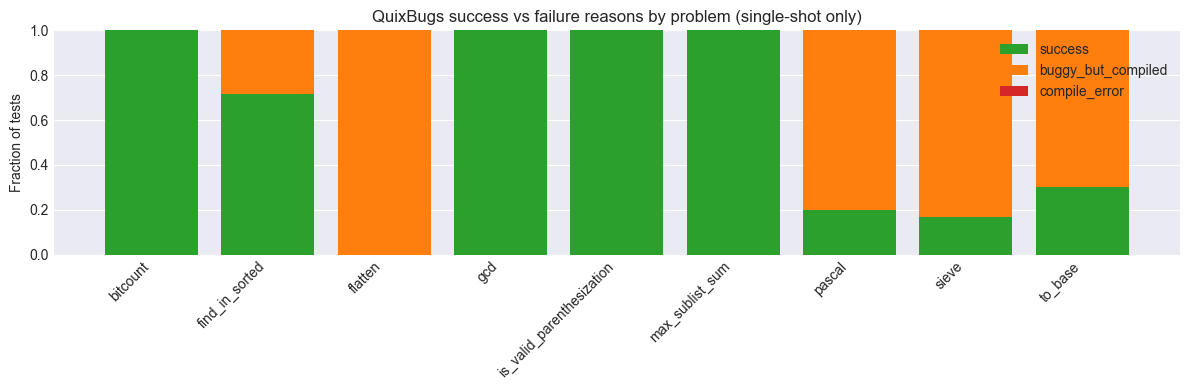

In [14]:
print("Loading QuixBugs problems from local folder (data/QuixBugs, Python subset)...")
local_problems = load_quixbugs_selection(QUIXBUGS_SELECTION)
if local_problems:
    print(f"Loaded {len(local_problems)} problems: " + ", ".join(p['name'] for p in local_problems))
    # Inspect how many tests each selected QuixBugs problem contributes
    for p in local_problems:
        print(f"  - {p['name']}: {len(p['tests'])} tests loaded for prompting and evaluation")
    local_report = evaluate_quixbugs_subset(local_problems, model=PRIMARY_MODEL)
    print("QuixBugs (local) single-shot results (pass@1 over problems):")
    print(f"pass@1: {local_report['pass_at_1']:.0%}")
    print(f"average pass rate: {local_report['average_pass_rate']:.0%}")
    for d in local_report['details']:
        print(f"  {d['name']}: {'PASS' if d['all_passed'] else 'FAIL'} ({d['pass_rate']:.0%})")
    # Per-problem visualization for single-shot baseline
    quixbugs_single_df = build_quixbugs_results_df(local_report)
    plot_quixbugs_results_stacked(quixbugs_single_df, title_suffix='(single-shot only)')
else:
    print("No local QuixBugs problems found at data/QuixBugs; please clone or download the benchmark there.")

### 1.6 Analyzing QuixBugs Results

The results above give us a snapshot of single-shot performance on a diverse benchmark. Take a moment to inspect the plots and the pass rates.

- **Pass@1**: How often does the model get it right on the first try?
- **Failure Types**: Are we seeing mostly compilation errors or logic bugs?

You will use these observations to answer **Question 2.4** below.

### Question 2 (Short Answer, 10 points): Evaluation, Specs, and Single-Shot Limitations

Based on your experimental results with both the **minimal tests** and the upgraded **STRICT tests/spec** for `binary_search`, as well as the **QuixBugs** benchmark, reflect on the following questions:

**Q2.1: Impact of Stronger Specs and Tests**
How did the single-shot success metrics (e.g., pass@1, average pass rate) change when you moved from the minimal tests to the STRICT tests? What does this tell you about how much our *evaluation setup* can hide or reveal model weaknesses?

**Q2.2: Failure Modes Under STRICT Tests**
Looking at the concrete failing cases under the STRICT tests (including duplicates, boundary cases, and any compilation errors), what patterns do you see in how the model fails? Are these small off-by-one issues, misunderstandings of the leftmost-index spec, extraction/compilation problems, or something else?

**Q2.3: Broader Implications for Agentic AI and Evaluation**
What challenges do these observations reveal for agentic AI or AI systems in general? Consider at least one of: (a) the difficulty of writing complete specifications, (b) the risk of overestimating model capability from weak tests, or (c) the need for iterative evaluation (e.g., pass@K, self-diagnosis, oracles) when building reliable agents.

**Q2.4: QuixBugs Performance**
Reflect on the QuixBugs results:
- Which problems are consistently solved vs. consistently failed? Do they share structural properties?
- How often do failures stem from compilation errors vs. buggy-but-compiled behavior?
- Based on the stacked failure plots, where would you focus improvement effort first (prompting, extraction, tests, or model choice)?

Summarize your answers to Q2.1–Q2.4 in a short paragraph or bullet list. Make sure to connect the quantitative changes in metrics to qualitative observations about failure modes and evaluation design.

### Question 3 (Coding/Design, 10 points): Prompt-Tuning for Single-Shot Debugging

**Goal:** Explore how different prompts affect single-shot debugging performance.

In this question, you will experiment with alternative prompts for `single_shot_debugging` and see how they change model behavior under both the minimal and STRICT tests.

**Your task:**
- Locate the baseline prompt used in `single_shot_debugging` (the multi-line `prompt = f"..."` string above).
- Design an alternative prompt (Prompt B) of your choice. You are free to choose the wording, but consider output-format rules so that code can be extracted correctly. For instance, the model should output **code only** (no explanations or markdown). It's part of the design considerations.
- Temporarily replace the baseline prompt with Prompt B, run your experiments, and then **restore the original prompt** when you are done.

For each prompt (Prompt A = baseline, Prompt B = your variant):
- On the **minimal tests** (`BINARY_SEARCH_TEST_CASES`), run `measure_single_shot_success` and record:
  - Compilation failure rate (fraction of attempts where `compilation != 'success'`).
  - Average pass rate (the `avg_pass_rate` from your function).
- On the **STRICT tests** (the upgraded spec and test suite later in this section), run the STRICT evaluation cells once with Prompt A and once with Prompt B, and record:
  - pass@1,
  - average pass rate,
  - at least one example of a failing attempt for each prompt.

**Reflection prompts:**
- Did Prompt B improve success rates? Under minimal tests, STRICT tests, or both?
- Did Prompt B change *how* the model fails (e.g., fewer compile errors, better handling of duplicates, or just different bugs)?
- What trade-offs did you see between giving more guidance vs. avoiding prompts that overfit to the specific tests?

You can briefly summarize your observations in your notes or use them to inform your answers to **Question 2 (Short Answer)**.

## Section 2: The ReAct Pattern - Reasoning and Acting


The ReAct (Reasoning and Acting) pattern, introduced by [Yao et al. (2022)](https://arxiv.org/abs/2210.03629), represents a breakthrough in making language models more capable and reliable. The key insight is to **interleave reasoning traces with actions**, creating a feedback loop that enables self-improvement.

#### The ReAct Cycle

1. **Thought**: The model reasons about the current state and what to do next
2. **Action**: Based on its reasoning, the model takes a specific action
3. **Observation**: The environment provides feedback about the action's result
4. **Repeat**: The model uses the observation to inform its next thought

This creates a form of "System 2" thinking for language models - deliberate, iterative problem-solving rather than quick, intuitive responses.

We'll build our ReAct system with clear separation of concerns:
- **Data structures** to track the reasoning trace
- **Generation functions** for thoughts and actions
- **Execution environment** for running actions
- **Evaluation metrics** to measure performance

In [15]:
@dataclass
class ReActStep:
    """
    Data structure for a single ReAct step.
    
    This encapsulates one iteration of the thought-action-observation cycle.
    Using a dataclass ensures consistent structure and makes the trace analyzable.
    """
    iteration: int      # Which iteration is this?
    thought: str        # What the model reasoned
    action: Dict       # Structured action to take
    observation: str    # Result from the environment
    success: bool      # Did this step achieve the goal?
    
def parse_json_safely(text: str) -> Optional[Dict]:
    """
    Safely parse JSON from model output.
    
    Language models often produce malformed JSON. This function attempts
    to extract and fix common issues before parsing.
    
    Args:
        text: Raw text that might contain JSON
        
    Returns:
        Parsed dictionary or None if parsing fails
    """
    # Strategy 1: Find the outer-most braces
    # This handles cases where the model wraps JSON in markdown or adds extra text
    start = text.find('{')
    end = text.rfind('}')
    
    if start != -1 and end != -1 and end > start:
        candidate = text[start:end+1]
        try:
            # strict=False allows control characters (like newlines) inside strings
            return json.loads(candidate, strict=False)
        except json.JSONDecodeError:
            pass
            
    # Strategy 2: Fallback to the original regexes
    json_patterns = [
        r'\{[^{}]*\}',  # Simple JSON object
        r'\{.*\}',       # Greedy JSON object  
    ]
    
    for pattern in json_patterns:
        matches = re.findall(pattern, text, re.DOTALL)
        for match in matches:
            try:
                # Fix common issues
                match = match.replace("'", '"')  # Single to double quotes
                match = re.sub(r',\s*}', '}', match)  # Remove trailing commas
                match = re.sub(r',\s*]', ']', match)  # Remove trailing commas in arrays
                
                # Attempt to parse
                return json.loads(match, strict=False)
            except json.JSONDecodeError:
                continue
            except Exception:
                continue
    
    # If no valid JSON found, return None
    return None

### Question 4 (Coding, 20 points): Implement Thought Generation

**Objective**: Understand how to prompt language models to generate high-quality reasoning traces that guide action selection in agentic systems. Thought generation is critical because it determines what the agent tries next based on past failures.

**Background**: In the ReAct pattern, thoughts serve as the reasoning layer. Good thoughts should:
- Analyze the current situation (what's been tried, what failed)
- Reference previous attempts and their outcomes
- Propose a hypothesis about what to try next
- Be specific and actionable (not vague like "fix the bug")

**Your Task**: Implement the thought generation component of our ReAct system. This function prompts the model to reflect on the problem and its progress, generating a reasoning trace that will inform the next action.

**Key Design Principle**: We deliberately separate thought generation (reasoning) from action generation (code production). This forces the model to plan before acting, which improves solution quality.

In [16]:
def generate_thought(task: str, history: List[ReActStep], model: str = PRIMARY_MODEL, verbose: bool = False):
    """
    Generate a reasoning step about what to do next.

    TODO: Student Implementation (10-15 lines)
    This function is the core coding task for **Question 4**.

    Your thought generation should:
    1. Create a prompt that includes the task and recent history
    2. If there's history, analyze what went wrong previously
    3. Generate a thought about what to try next
    4. Optionally return the prompt for educational/debugging purposes

    Implementation strategy:
    - Start with the task description in your prompt
    - If history exists, include the last 1-2 attempts with their observations
    - Focus on what went wrong and why (e.g., "failed because...")
    - Ask the model to reason about the next step, not generate code
    - Use ollama.chat() to get the model's reasoning
    - Return the thought as a string (or tuple if verbose=True)

    Args:
        task: The current task/problem
        history: List of previous ReActStep objects
        model: Model to use
        verbose: If True, return (prompt, thought) tuple for debugging/education

    Returns:
        str: A thought/reasoning string (if verbose=False)
        tuple: (prompt, thought) if verbose=True - useful for debugging and education

    **Why verbose mode?** In production agentic systems, understanding the full
    prompt-response cycle is crucial for:
    - Debugging unexpected behaviors
    - Learning prompt engineering through observation
    - Understanding how context affects reasoning
    - Iterating on prompt design

    HINTS:
    - Build a prompt string that includes context about the task
    - Conditionally add information from recent history (if available)
    - In your prompt, explicitly request reasoning/analysis, not code
    - Use the ollama wrapper to call the model with your prompt
    - Extract and return the text content from the model's response
    - If verbose=True, return (prompt, thought) tuple instead of just thought

    Example thought: "The previous attempt failed because the search interval
    wasn't updated correctly after checking mid. I should adjust how left and
    right are updated in binary_search to avoid off-by-one errors."
    """

    # TODO: Build the prompt
    # Start with the task description to anchor the model's reasoning.
    # This ensures all thoughts stay focused on the original goal.
    prompt = f"Task: {task}\n\n"
    
    # TODO: Add history context (if any)
    # HINT: The history tells the model what it has already tried.
    # 1. Check if 'history' is not empty.
    # 2. Iterate through the last few steps (e.g., history[-2:]).
    # 3. For each step, include the 'thought' and the 'observation'.
    # 
    # EDUCATIONAL NOTE: We only include the last 2 attempts to:
    # 1. Keep context window manageable for small models
    # 2. Focus on recent failures (most relevant for next attempt)
    # 3. Avoid overwhelming the model with too much history
    if history:
        prompt += "Previous attempts:\n"
        # Look at last 2 attempts to learn from recent failures
        for step in history[-2:]:
            # Truncate thought to 100 chars to keep prompt concise
            prompt += f"  Attempt {step.iteration}: {step.thought[:100]}...\n"
            # Include full observation - this is the critical feedback signal
            prompt += f"  Result: {step.observation}\n\n"
        prompt += "Based on these previous attempts, "
    else:
        prompt += "This is your first attempt. "

    # TODO: Add instruction for thought generation
    # CRITICAL: Explicitly tell the model NOT to write code yet.
    # We want it to "think" (plan) before it "acts" (codes).
    # This separation prevents the model from rushing into a bad solution.
    # HINT: Explicitly tell the model to:
    # 1. Analyze the situation.
    # 2. Plan the next step.
    # 3. NOT write code yet (this is crucial for ReAct).
    #
    # EDUCATIONAL NOTE: We explicitly tell the model NOT to write code yet.
    # This separation of concerns (thinking vs. doing) is key to ReAct:
    # - Thought: "Why did X fail? I should try Y because..."
    # - Action: "Here's the code implementing Y"
    prompt += """think step-by-step about what to do next.

Analyze:
1. What exactly failed in the previous attempt? (Look at the observation)
2. Why did your previous fix not work?
3. What DIFFERENT approach will you try now? (Do not repeat the same fix)

Provide your reasoning (2-3 sentences). Do NOT write code yet, just explain your thinking."""

    # TODO: Call the model and get the thought
    # HINT: Use ollama.chat(model=model, messages=[...])
    # The 'messages' list should contain a single dictionary: {'role': 'user', 'content': prompt}
    response = ollama.chat(model=model, messages=[{'role': 'user', 'content': prompt}])
    thought = response['message']['content']

    # TODO: Return based on verbose mode
    # HINT:
    # - If verbose is True, return a tuple: (prompt, thought)
    # - If verbose is False, return just the string: thought
    #
    # EDUCATIONAL NOTE: The verbose mode is especially useful for:
    # - Understanding why the model gave a particular response
    # - Debugging prompt engineering issues
    # - Teaching students about the prompt-response relationship
    if verbose:
        return prompt, thought
    return thought

In [17]:

# =============================================================================
# Test Suite for Question 4: Thought Generation
# =============================================================================
# These tests help you verify your implementation and understand the ReAct
# reasoning process. We use verbose=True to show BOTH the prompt and response,
# which is crucial for understanding prompt engineering and debugging.
#
# Key Learning Objectives:
# 1. See how prompts are constructed with/without history
# 2. Understand how model responses adapt to different contexts
# 3. Observe the cause-and-effect relationship between prompt and output
# 4. Learn to debug model behaviors by inspecting prompts

print("=" * 80)
print("TEST 1: Generating thought WITHOUT history")
print("=" * 80)
print()
print("📚 CONTEXT: This simulates the agent's first attempt at a task.")
print("   The model has no prior failures to learn from, so it will")
print("   provide a general analysis of the problem.\n")

# TODO: Student - Call generate_thought with verbose=True
# HINT: Use unpacking to get both prompt and thought: prompt, thought = generate_thought(...)
# HINT: The verbose parameter should be set to True
prompt_no_history, thought_no_history = generate_thought(
    "Fix the binary_search function",
    [],
    verbose=True
)

print("📤 PROMPT SENT TO LLM:")
print("-" * 80)
print(prompt_no_history)
print()

print("📥 LLM RESPONSE:")
print("-" * 80)
print(thought_no_history)
print()


# =============================================================================
# Test 2: With History
# =============================================================================
print("\n" + "=" * 80)
print("TEST 2: Generating thought WITH history")
print("=" * 80)
print()
print("📚 CONTEXT: This simulates an agent that has tried twice and failed.")
print("   Notice how the prompt now includes previous attempts and their")
print("   failures. The model should reflect on WHY they failed and propose")
print("   a better approach.\n")

# Create fake history with two failed attempts
# This simulates a realistic debugging scenario where:
# 1. First attempt had a syntax error (easy to fix)
# 2. Second attempt had logical errors (requires deeper reasoning)
fake_history = [
    ReActStep(
        iteration=1,
        thought="I tried adjusting the right boundary of the search interval.",
        action={"tool": "fix_code", "params": {"code": "..."}},
        observation="Compilation error: syntax error on line 3",
        success=False,
    ),
    ReActStep(
        iteration=2,
        thought="I fixed the syntax but the tests are still failing for duplicate values.",
        action={"tool": "fix_code", "params": {"code": "..."}},
        observation=(
            "Pass rate: 50%. Example failing test: "
            "([1,2,2,2,3], 2) -> expected 1, got 2"
        ),
        success=False,
    ),
]

# TODO: Student - Call generate_thought with history and verbose=True
# HINT: Pass fake_history as the second argument
# HINT: Use verbose=True to see both prompt and response
prompt_with_history, thought_with_history = generate_thought(
    "Fix the binary_search function",
    fake_history,
    verbose=True
)

print("📤 PROMPT SENT TO LLM:")
print("-" * 80)
print(prompt_with_history)
print()

print("📥 LLM RESPONSE:")
print("-" * 80)
print(thought_with_history)
print()

TEST 1: Generating thought WITHOUT history

📚 CONTEXT: This simulates the agent's first attempt at a task.
   The model has no prior failures to learn from, so it will
   provide a general analysis of the problem.

📤 PROMPT SENT TO LLM:
--------------------------------------------------------------------------------
Task: Fix the binary_search function

This is your first attempt. think step-by-step about what to do next.

Analyze:
1. What exactly failed in the previous attempt? (Look at the observation)
2. Why did your previous fix not work?
3. What DIFFERENT approach will you try now? (Do not repeat the same fix)

Provide your reasoning (2-3 sentences). Do NOT write code yet, just explain your thinking.

📥 LLM RESPONSE:
--------------------------------------------------------------------------------
1. The previous attempt failed to return the correct index for the target value during the search.
2. The previous attempt likely used a conditional statement to check for the target valu

#### Self-Check: Thought Generation & Prompt Design (Optional)

After reviewing the outputs above, you may briefly reflect on:

- **Prompt vs. History**: How does adding recent attempts and outcomes change the model's
  reasoning compared to the first attempt with no history?
- **Reasoning Quality**: Does the second response use history to propose more concrete
  next steps, or does it stay vague?
- **Prompt Design**: What single change to the thought prompt (wording, structure, or
  instructions) might most improve the model's reasoning for this task or a similar
  real-world debugging setting?

### Question 5 (Coding, 20 points): Implement Action Generation

**Objective**: Learn how to convert reasoning traces (thoughts) into structured, executable actions. This is where the ReAct pattern translates plans into concrete steps the agent can take.

**Background**: After the model generates a thought about what to try next, we need to convert that reasoning into a structured action. In our code debugging domain, actions are JSON objects like:
```json
{"tool": "fix_code", "params": {"code": "def binary_search(...)..."}}
```

**Why JSON?** Structured output enables:
- Reliable parsing (vs. free-form text)
- Type safety (we know what fields to expect)
- Tool routing (the "tool" field determines what happens next)
- Composability (easy to add new tools later)

**Your Task**: Implement action generation that prompts the model to produce valid JSON actions based on its reasoning. You'll also handle parsing failures gracefully - a critical skill when working with small models that sometimes produce malformed output.

**Design Note**: The helpers you build here (generate_thought and generate_action) are intentionally generic: they should work for any debugging task described in the task string, not just the binary_search example. Later, we'll reuse the same components on the QuixBugs benchmark.

In [18]:
def generate_action(thought: str, task: str, model: str = PRIMARY_MODEL) -> Dict:
    """
    Generate a structured action based on the thought.
    
    TODO: Student Implementation (10-12 lines)
    This function is the core coding task for **Question 5**.
    1. Create a prompt that converts thought into action
    2. Request a specific JSON format
    3. Parse and validate the response
    
    Implementation strategy:
    - Create a prompt that includes the thought and task
    - Request JSON in format: {"tool": "fix_code", "params": {"code": "..."}}
    - Call ollama.chat() to get the model's response
    - Use parse_json_safely() to extract JSON from the response
    - Validate that 'tool' and 'params' keys exist
    - If parsing fails or invalid, return error action
    
    Args:
        thought: The reasoning about what to do
        task: The original task
        model: Model to use
        
    Returns:
        Dictionary with 'tool' and 'params' keys
        
    HINTS:
    - Create a prompt that provides the thought and task as context
    - In your prompt, specify the exact JSON structure you want
    - Call the model to generate the JSON action
    - Use the provided parse_json_safely() helper to extract valid JSON
    - Validate the parsed result has required keys before returning
    - Return an error action dictionary if validation fails
    """

    # TODO: Create prompt for action generation
    # We force the model to output JSON so our code can reliably parse it.
    # Natural language is hard for machines to read; JSON is easy.
    # We include both the thought (reasoning) and task (context) to help the model
    # generate appropriate code.
    prompt = f"""Based on this reasoning:
{thought}

Task: {task}

Generate a JSON action in this exact format:
{{"tool": "fix_code", "params": {{"code": "<Python function implementation>"}}}}

IMPORTANT:
1. The "code" value must be a SINGLE string with `\\n` for newlines.
2. Do NOT use markdown code blocks (```) inside the JSON.
3. Return ONLY the JSON object."""

    # TODO: Call the model
    # HINT: Use ollama.chat() again.
    #
    # EDUCATIONAL NOTE: Some models struggle with JSON output. Common issues:
    # - Extra text before/after JSON
    # - Single quotes instead of double quotes
    # - Trailing commas
    # - Missing closing braces
    # This is why we need robust parsing in the next step!
    response = ollama.chat(model=model, messages=[{'role': 'user', 'content': prompt}])
    response_text = response['message']['content']

    # TODO: Parse the response
    # HINT: Use the helper function parse_json_safely(response_text).
    #
    # EDUCATIONAL NOTE: parse_json_safely() handles common JSON errors:
    # 1. Extracts JSON patterns with regex
    # 2. Fixes single quotes → double quotes
    # 3. Removes trailing commas
    # This makes our system robust to small model output quality issues
    parsed_action = parse_json_safely(response_text)

    # TODO: Validate and return
    # HINT:
    # 1. Check if parsed_action is not None.
    # 2. Check if it has the required keys: 'tool' and 'params'.
    # 3. If valid, return the parsed_action.
    # 4. If invalid, return a dictionary with tool="error" and a message in params.
    #
    # EDUCATIONAL NOTE: Always validate structured output before using it!
    # This prevents crashes when the model produces unexpected formats.
    # Our error action {"tool": "error", ...} follows the same structure,
    # so downstream code can handle it uniformly.
    if parsed_action and 'tool' in parsed_action and 'params' in parsed_action:
        return parsed_action
    else:
        return {"tool": "error", "params": {"message": "Failed to parse valid action from model response"}}

# Test your implementation (students can use this as a self-check)
test_action = generate_action(
    "The current function implementation is failing some tests and likely has a logic bug.",
    "Fix the binary_search function",
)
print("Generated action (basic structure check):")
print(json.dumps(test_action, indent=2))

# Simple structural check: we expect a 'fix_code' tool with a 'code' field in params.
if test_action.get('tool') != 'fix_code' or 'code' not in test_action.get('params', {}):
    print(
        "Warning: expected tool='fix_code' with a 'code' field in 'params'.\n"
        "Check that your generate_action prompt requests the exact JSON format and that "
        "parse_json_safely is used correctly."
    )

Generated action (basic structure check):
{
  "tool": "fix_code",
  "params": {
    "code": "def binary_search(array, target):  left = 0  right = len(array) - 1  while left <= right:    mid = (left + right) // 2    if array[mid] == target:      return mid    elif array[mid] < target:      left = mid + 1    else:      right = mid - 1  return -1\n# Example usage\ntest_array = [2, 5, 7, 8, 11, 12]\nprint(binary_search(test_array, 11))\n"
  }
}


### Question 6 (Coding, 25 points): Complete the ReAct Loop

**Objective**: Implement the complete ReAct control flow that orchestrates thought generation, action generation, action execution, and observation collection. This is where all the components come together into an agentic system.

**Background**: The ReAct loop is the heart of an agentic system. It repeatedly:
1. **Think**: Generate a thought based on task and history
2. **Act**: Convert thought into a structured action
3. **Execute**: Run the action (in our case, test code)
4. **Observe**: Collect feedback from the environment
5. **Decide**: Continue iterating or stop if successful

This cycle enables the agent to learn from failures and adapt its approach.

**Your Task**: Complete the main loop that coordinates these components. You'll implement the iteration logic, state management (tracking history), and termination conditions.

**Key Design Decisions**:
- **Max iterations**: Prevents infinite loops (agent might never solve hard problems)
- **Success criteria**: What counts as "done"? (all tests passing in our case)
- **History tracking**: Each iteration adds a ReActStep to enable learning
- **Verbose mode**: Helps debug agent behavior by showing intermediate steps

In [19]:
def react_loop(
    task: str,
    buggy_code: str,
    test_cases: List[Tuple],
    max_iterations: int = 5,
    model: str = PRIMARY_MODEL,
    verbose: bool = True
) -> Tuple[str, List[ReActStep]]:
    """
    Complete ReAct loop for code debugging.
    
    TODO: Student Implementation (20-30 lines)
    This function is the core coding task for **Question 6**.
    Complete the main loop that coordinates thought, action, and observation.
    
    Args:
        task: Description of the task
        buggy_code: The buggy code to fix
        test_cases: Test cases to validate against
        max_iterations: Maximum iterations before giving up
        model: Model to use
        verbose: Whether to print progress
        
    Returns:
        Tuple of (final_code, history)
        
    IMPLEMENTATION STEPS:
    1. Initialize history list and current_code
    2. Loop for max_iterations
    3. Generate thought using generate_thought()
    4. Generate action using generate_action()
    5. Execute action (if tool is "fix_code", extract code from params)
    6. Create observation by testing the code
    7. Check if all tests pass - if yes, break
    8. Add step to history
    9. Return final code and history
    """
    
    # Initialize state variables
    # history: accumulates all ReActSteps for analysis and learning
    # current_code: the candidate solution we're testing
    # final_code: the best solution we've found (returned at the end)
    history = []
    current_code = buggy_code
    final_code = buggy_code

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n--- Iteration {iteration + 1} ---")

        # TODO: Step 1 - Generate thought
        # HINT: Call generate_thought(task, history, model)
        #
        # EDUCATIONAL NOTE: The thought generation sees the entire history,
        # allowing it to learn from past failures. This is the key difference
        # from single-shot approaches - the agent can reflect and adapt.
        thought = generate_thought(task, history, model)

        if verbose:
            print(f"Thought: {thought[:100]}...")

        # TODO: Step 2 - Generate action
        # HINT: Call generate_action(thought, task, model)
        #
        # EDUCATIONAL NOTE: We pass both the thought (what to try) and
        # the task (what we're solving) to ground the action generation.
        action = generate_action(thought, task, model)

        if verbose:
            print(f"Action: {action['tool']}")

        # TODO: Step 3 - Execute action
        # HINT:
        # 1. Check if action['tool'] is 'fix_code'.
        # 2. If so, extract the code from action['params']['code'].
        # 3. Update current_code and final_code with this new code.
        #
        # EDUCATIONAL NOTE: We validate the action before executing.
        # If action parsing failed, action['tool'] will be 'error',
        # and we'll skip code extraction (current_code stays unchanged).
        # This defensive programming prevents crashes from malformed actions.
        if action['tool'] == 'fix_code' and 'code' in action.get('params', {}):
            current_code = action['params']['code']
            final_code = current_code

        # TODO: Step 4 - Test the code
        # HINT: Call execute_code_safely(current_code, test_cases)
        #
        # EDUCATIONAL NOTE: We always test current_code, even if action
        # extraction failed. This provides useful feedback ("still broken")
        # rather than silently continuing with old code.
        test_results = execute_code_safely(current_code, test_cases)

        # TODO: Step 5 - Create observation string
        # HINT: Create a string that summarizes the test results.
        # - If compilation failed, say "Compilation error: ..."
        # - If tests failed, say "Pass rate: X%. Failed: <example>"
        # - If all passed, say "All tests passed!"
        #
        # EDUCATIONAL NOTE: The observation is the agent's primary feedback signal.
        # We format it to be maximally informative:
        # - Compilation errors: exact error message (helps fix syntax)
        # - Test failures: show one concrete failing case (helps fix logic)
        # - Success: confirm all tests passed (enables termination)
        if test_results['compilation'] != 'success':
            observation = f"Compilation error: {test_results['compilation']}"
        else:
            observation = f"Pass rate: {test_results['pass_rate']:.0%}. "
            failed_tests = [t for t in test_results['test_results'] if not t['passed']]
            if failed_tests:
                # Show first failing test as concrete example
                observation += f"Failed: {failed_tests[0]}"
            else:
                observation += "All tests passed!"

        # TODO: Step 6 - Check success
        # HINT: success = test_results['all_passed']
        #
        # EDUCATIONAL NOTE: Success means ALL tests passed, not just some.
        # This is important for correctness - partial solutions aren't enough.
        success = test_results.get('all_passed', False)

        # TODO: Step 7 - Create and add ReActStep to history
        # HINT: Create a ReActStep object with all the current iteration data
        # and append it to the history list.
        #
        # EDUCATIONAL NOTE: We record every step, even failures.
        # This history enables:
        # 1. Future iterations to learn from mistakes
        # 2. Post-hoc analysis of agent behavior
        # 3. Debugging when things go wrong
        step = ReActStep(
            iteration=iteration + 1,
            thought=thought,
            action=action,
            observation=observation,
            success=success
        )
        history.append(step)

        # TODO: Step 8 - Break if successful
        # We stop immediately once we find a working solution ("greedy" approach).
        # In a more advanced system, you might keep searching to find a *better* solution.
        # HINT: If success is True, break the loop.
        #
        # EDUCATIONAL NOTE: We stop as soon as we solve the problem.
        # This is the "greedy" termination strategy. Alternatives include:
        # - Continue to find multiple solutions (for diversity)
        # - Continue to improve solution quality (for optimization)
        if success:
            break

        if verbose:
            print(f"Success: {success}")

    return final_code, history

# Test your implementation
print("Testing ReAct Loop Implementation\n")
fixed_code, history = react_loop(
    "Fix the binary_search function", 
    BUGGY_BINARY_SEARCH, 
    STRICT_TESTS,
    max_iterations=5
)

print(f"\nFinal Results:")
print(f"  Iterations used: {len(history)}")
print(f"  Success: {history[-1].success if history else False}")

Testing ReAct Loop Implementation


--- Iteration 1 ---
Thought: 1. The previous function returned -1. This indicates that it failed to find the target element.
2. T...
Action: fix_code

Final Results:
  Iterations used: 1
  Success: True


### Required Analysis for Question 6

After running the ReAct loop on the `binary_search` task (and optionally on a few QuixBugs problems), reflect on:
- How often does ReAct succeed compared to the single-shot baseline (on the same tests)?
- On average, how many iterations does ReAct need when it succeeds? What does this say about the cost of iteration?
- When ReAct fails, which component seems most responsible (thought quality, action JSON validity, or tool feedback)?
- Based on your traces, what concrete change would you try next to improve the agent?

Summarize your observations in a brief written answer, making sure to tie them back to the earlier single-shot metrics and STRICT tests.

## Bonus Explorations: Advanced Topics in Agentic AI

You've now built a working ReAct agent and evaluated it on real debugging tasks. The sections below offer four independent directions for deeper exploration. **Choose one** as a bonus project worth up to 20 additional points.

Each option includes:
- **Objective**: What you'll investigate
- **Why it matters**: Real-world relevance
- **Suggested approach**: Key ideas and code patterns (not a full implementation)
- **Deliverables**: What to submit
- **Evaluation criteria**: How your work will be assessed

These are intentionally open-ended. We provide starting points, but you have freedom to explore directions that interest you.

---
### Bonus Option A: Component-Level Evaluation

**Objective**

When a ReAct loop fails, where did things go wrong? Was the reasoning poor? Did action parsing fail? Did the agent converge too slowly? End-to-end success rate tells you *if* your agent works, but component-level metrics tell you *why*.

**Why it matters**

Production agentic systems need targeted debugging. If your agent has 60% success rate, you need to know whether to improve the prompt (thought quality), the output parser (action validity), or the tool feedback (observation richness). Component metrics guide engineering effort toward the highest-impact improvements.

**Suggested approach**

Build an evaluation framework that scores each component independently:

1. **Thought quality**: Does the reasoning reference previous failures? Is it specific and actionable? You can use keyword matching (e.g., presence of "because", "failed", "try instead") or ask a second LLM call to rate the thought on a 1-5 scale.

2. **Action validity**: What percentage of generated actions parse as valid JSON with the expected schema? Track `tool` and `params` fields separately.

3. **Convergence speed**: How many iterations until success (or max iterations)? Plot the distribution across multiple trials.

**Deliverables**

1. A brief report (1-2 pages) describing your evaluation methodology
2. Results from running at least 10 trials, showing:
   - Distribution of thought quality scores
   - Action validity rate
   - Correlation between component scores and overall success
3. One visualization (e.g., box plot of component scores, or scatter plot of thought quality vs. success)
4. A paragraph identifying which component is the bottleneck in your system and why

**Evaluation criteria**

- Soundness of evaluation methodology (do your metrics actually measure what you claim?)
- Quality of analysis (do you draw meaningful conclusions from the data?)
- Clarity of presentation

---
### Bonus Option B: Tool Design Principles

**Objective**

The quality of feedback from tools dramatically affects agent performance. A tool that returns "Error" gives the agent nothing to learn from. A tool that returns "SyntaxError at line 5: unexpected indent" enables targeted fixes. Investigate how tool design impacts ReAct effectiveness.

**Why it matters**

In production systems, you often control tool design but not model capabilities. Understanding what makes tools effective lets you maximize agent performance without changing the underlying LLM. This principle applies across domains: code execution, web search, database queries, API calls.

**Suggested approach**

Compare ReAct performance with tools that vary in feedback richness:

1. **Minimal feedback**: Returns only "Success" or "Error"
2. **Basic feedback**: Returns error type and pass/fail count
3. **Rich feedback**: Returns error location, failing test cases with inputs/outputs, and hints

Key code patterns to consider:
```python
def minimal_executor(code: str, tests: List) -> str:
    """Minimal feedback - just success/error."""
    try:
        # ... execute code ...
        return "Success" if all_passed else "Error"
    except:
        return "Error"

def rich_executor(code: str, tests: List) -> str:
    """Rich feedback with diagnostic information."""
    try:
        namespace = {}
        exec(code, namespace)
    except SyntaxError as e:
        return f"SyntaxError at line {e.lineno}: {e.msg}\nProblematic code: {e.text}"
    except Exception as e:
        return f"RuntimeError: {type(e).__name__}: {e}"
    
    # Run tests and show first failure in detail
    for test_input, expected in tests:
        actual = namespace['func'](test_input)
        if actual != expected:
            return f"Test failed: input={test_input}, expected={expected}, got={actual}"
    return "All tests passed!"
```

Run experiments comparing success rate and iteration count across tool designs. Consider:
- Does richer feedback reduce iterations needed?
- Are there diminishing returns to feedback detail?
- Does feedback style matter (structured vs. natural language)?

**Deliverables**

1. Implementation of at least two tool variants with different feedback richness
2. Experimental results from at least 10 trials per tool variant, showing:
   - Success rate comparison
   - Average iterations to solution
3. A table or chart comparing the tool variants
4. A short discussion (0.5-1 page) extracting 3-5 principles for effective tool design that would generalize to other domains

**Evaluation criteria**

- Experimental rigor (controlled comparison, sufficient trials)
- Insight quality (do your principles generalize beyond code debugging?)
- Practical applicability of recommendations

---
### Bonus Option C: Comparative Analysis of Small Language Models

**Objective**

Different models exhibit distinct behaviors in agentic contexts. Some excel at reasoning but struggle with structured output. Others reliably generate valid JSON but make logical errors. Systematically compare models to understand these trade-offs.

**Why it matters**

Model selection for agentic applications differs from model selection for chat or completion. A model that writes beautiful prose might fail at generating valid JSON actions. Understanding model-specific strengths helps you choose the right model for your use case and design appropriate scaffolding.

**Suggested approach**

Benchmark 2-3 models on multiple dimensions:

1. **Task success rate**: What percentage of problems does each model solve?
2. **Structural reliability**: What percentage of actions are valid JSON with correct schema?
3. **Reasoning quality**: How specific and actionable are the generated thoughts?
4. **Efficiency**: How many tokens/iterations does each model need?

Key considerations for fair comparison:
```python
# Use identical prompts across models
STANDARD_THOUGHT_PROMPT = """..."""
STANDARD_ACTION_PROMPT = """..."""

# Run multiple trials to account for variance
N_TRIALS = 5

# Track multiple metrics per trial
def benchmark_model(model_name: str, n_trials: int) -> Dict:
    results = []
    for _ in range(n_trials):
        fixed_code, history = react_loop(task, buggy_code, tests, model=model_name)
        results.append({
            'success': history[-1].success if history else False,
            'iterations': len(history),
            'valid_json_rate': sum(1 for s in history if s.action.get('tool') != 'error') / len(history),
            # ... other metrics
        })
    return aggregate_results(results)
```

Consider visualizations like:
- Bar charts comparing success rates
- Radar/spider charts showing multi-dimensional performance
- Heatmaps of model × metric scores

**Deliverables**

1. Benchmark results for at least 2 models across at least 3 metrics
2. Visualizations comparing model performance
3. A short analysis (0.5-1 page) addressing:
   - Which model performs best overall? On which metrics?
   - Are there trade-offs (e.g., better reasoning vs. better structured output)?
   - What does this suggest about model selection for agentic applications?

**Evaluation criteria**

- Experimental design (fair comparison, controlled variables)
- Depth of analysis (beyond just "model X is better")
- Quality of visualizations

---
### Bonus Option D: Failure Mode Analysis and Recovery

**Objective**

Agentic systems fail in systematic, predictable ways. Identifying and categorizing these failure modes enables targeted improvements. Go beyond measuring success rate to understand *how* and *why* your agent fails.

**Why it matters**

In production, you can't just report "40% failure rate." You need to know: Are failures due to parsing errors (fixable with better prompts)? Infinite loops (fixable with detection)? Fundamental reasoning limitations (requires model upgrade)? Failure analysis guides engineering priorities.

**Suggested approach**

Build a failure taxonomy and analyzer:

1. **Failure categories**:
   - `infinite_loop`: Agent repeats the same action 3+ times
   - `invalid_json`: More than half of actions fail to parse
   - `syntax_error`: Generated code has syntax errors
   - `logic_error`: Code compiles but fails tests
   - `gives_up`: Agent produces empty or non-code actions
   - `timeout`: Exceeds max iterations without success

2. **Recovery strategies**: Once you identify failure modes, implement targeted recovery:
   - For loops: Inject a prompt saying "You're repeating yourself. Try a completely different approach."
   - For syntax errors: Add a "focus on syntax first" hint
   - For logic errors: Include the failing test case in the next prompt

**Deliverables**

1. A failure taxonomy with at least 4 categories
2. Results from analyzing at least 15 failed trials, showing:
   - Distribution of failure modes (pie chart or bar chart)
   - Examples of each failure type
3. Implementation of at least one recovery strategy
4. Before/after comparison showing whether recovery improves success rate
5. A short discussion (0.5 page) on which failures are model-related vs. implementation-related

**Evaluation criteria**

- Completeness of failure taxonomy
- Quality of failure analysis
- Effectiveness of recovery strategy
- Insight into root causes

---
### Submission Guidelines for Bonus Projects

**Format**: Submit a Jupyter notebook or PDF containing your analysis. Include:
- Code cells showing your implementation (does not need to be runnable, but should be readable)
- Results and visualizations
- Written analysis addressing the deliverables

**Length**: 3-5 pages total (including figures)

**Grading**: Up to 20 bonus points based on:
- Technical correctness (40%)
- Depth of analysis (30%)
- Clarity of presentation (20%)
- Creativity and insight (10%)

---
## Final Reflection

Whether or not you complete a bonus project, take a few minutes to reflect on what you've learned:

**Synthesis questions** (no submission required, but worth thinking about):

1. **Where does intelligence reside?** In the ReAct loop you built, is the intelligence in the model, the scaffolding (prompts, tools, loop structure), or the interaction between them?

2. **Generalization**: How would you adapt the ReAct pattern to a completely different domain (medical diagnosis, financial analysis, creative writing)? What would thoughts, actions, and observations look like?

3. **Trade-offs**: Iteration improves performance but adds latency and cost. How would you determine the right balance for a specific application?

4. **Safety**: Agentic systems can take real-world actions. What safeguards would you implement for a production agent that executes code or modifies files?

The techniques you've learned form the foundation for building robust agentic systems. As you apply these patterns to new domains, remember: the goal isn't perfection on the first try, but systems that recognize and correct their own mistakes.

## Conclusions

In this notebook, you:
- Built a **single-shot debugging baseline** and saw how weak specs and tests can dramatically overestimate model capability.
- Strengthened the specification with STRICT tests and a real benchmark (QuixBugs), revealing more realistic single-shot limits.
- Implemented a **ReAct-style agent** that iterates through thoughts, actions, and observations instead of committing to a single guess.
- Explored how evaluation choices (pass@K, average pass rate, component-level metrics) shape your understanding of agent performance.

Taken together, these pieces illustrate that much of the "intelligence" in agentic systems comes from the **scaffolding** you design: prompts, tools, tests, and control loops, not just from the base model.


## References and Acknowledgments

- **ReAct framework**: Yao et al., 2022, "ReAct: Synergizing Reasoning and Acting in Language Models".
- **QuixBugs benchmark**: Lin et al., a collection of classic algorithmic bugs and tests used here as a small, realistic debugging suite.
- **Machine Learning: Learn by Building**: This notebook is part of the broader course materials developed by Prof. Ming Jin.

Large language models and tools were used as assistants in drafting portions of this notebook. All code, prompts, and analysis prompts were curated and reviewed to align with the educational goals of the course.